# Image decompression and azimuthal integration on the GPU

This tutorial explains how it is possible to speed-up azimuthal integration by speeding-up the critical part: the data transfer to the GPU.

For this tutorial, a very recent version of `silx` is needed, newer than fall 2022 (available in release 1.2)

**Credits:**

* Thomas Vincent (ESRF) for the HDF5 direct chunk read and the Jupyter-slurm
* Jon Wright (ESRF) for the initial prototype of the bitshuffle-LZ4 decompression on the GPU
* Pierre Paleo (ESRF) for struggling with this kind of stuff with GPUs

**Nota:** a (fast) GPU is needed for this tutorial with OpenCL properly setup !

The example taken here is the same as the multithreading example: 4096 frames of Eiger_4M

In [1]:
%matplotlib inline
# use `widget` for better user experience; `inline` is for documentation generation

In [2]:
import sys, os, collections, struct, time, resource
import numpy, pyFAI
import h5py, hdf5plugin
from matplotlib.pyplot import subplots
import bitshuffle
import pyopencl.array as cla
import silx
from silx.opencl import ocl
from silx.opencl.codec.bitshuffle_lz4 import BitshuffleLz4
start_time = time.time()
ocl

OpenCL devices:
[0] NVIDIA CUDA: (0,0) NVIDIA RTX A5000, (0,1) Quadro P2200
[1] Portable Computing Language: (1,0) cpu-haswell-AMD Ryzen Threadripper PRO 3975WX 32-Cores
[2] Intel(R) OpenCL: (2,0) AMD Ryzen Threadripper PRO 3975WX 32-Cores

In [3]:
#Here we select the OpenCL device
target = (0,0)

## Setup the enviroment:

This is a purely virtual experiment, we will use an Eiger 4M detector with data integrated over 1000 bins. Those parameters can be tuned.

Random data are generated, to keep this file fairly small, it is generated with small numbers which compress nicely. The speed of the drive where you will put the file is likely to have a huge impact !

In [4]:
det = pyFAI.detector_factory("eiger_4M")
shape = det.shape
dtype = numpy.dtype("uint32")
filename = "/tmp/big.h5"
nbins = 1000
cmp = hdf5plugin.Bitshuffle()
hdf5plugin.get_config()

HDF5PluginConfig(build_config=HDF5PluginBuildConfig(openmp=False, native=False, bmi2=False, sse2=True, ssse3=False, avx2=False, avx512=False, cpp11=True, cpp14=True, cpp20=True, ipp=False, filter_file_extension='.so', embedded_filters=('blosc', 'blosc2', 'bshuf', 'bzip2', 'fcidecomp', 'lz4', 'sperr', 'sz', 'sz3', 'zfp', 'zstd')), registered_filters={'bshuf': '/users/kieffer/.venv/py313/lib/python3.13/site-packages/hdf5plugin/plugins/libh5bshuf.so', 'blosc': '/users/kieffer/.venv/py313/lib/python3.13/site-packages/hdf5plugin/plugins/libh5blosc.so', 'blosc2': '/users/kieffer/.venv/py313/lib/python3.13/site-packages/hdf5plugin/plugins/libh5blosc2.so', 'bzip2': '/users/kieffer/.venv/py313/lib/python3.13/site-packages/hdf5plugin/plugins/libh5bzip2.so', 'fcidecomp': '/users/kieffer/.venv/py313/lib/python3.13/site-packages/hdf5plugin/plugins/libh5fcidecomp.so', 'lz4': '/users/kieffer/.venv/py313/lib/python3.13/site-packages/hdf5plugin/plugins/libh5lz4.so', 'sperr': '/users/kieffer/.venv/py313

In [5]:
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
target_bytes = 64 * 1<<30  # 64GB
print(f"Number of frames the computer can host in memory: {mem_bytes/(numpy.prod(shape)*dtype.itemsize):.3f}")
if os.environ.get('SLURM_MEM_PER_NODE'):
    print(f"Number of frames the computer can host in memory with SLURM restrictions: {int(os.environ['SLURM_MEM_PER_NODE'])*(1<<20)/(numpy.prod(shape)*dtype.itemsize):.3f}")
elif mem_bytes>target_bytes:
    print("Limit process to 64GB memory, i.e. ~ 3800 frames")
    soft, hard = resource.getrlimit(resource.RLIMIT_AS)
    resource.setrlimit(resource.RLIMIT_AS, (target_bytes, target_bytes))

Number of frames the computer can host in memory: 30143.226
Limit process to 64GB memory, i.e. ~ 3800 frames


In [6]:
#The computer being limited to 64G of RAM, the number of frames actually possible is 3800.
nbframes = 4096 # slightly larger than the maximum achievable ! Such a dataset should not host in memory.

In [7]:
#Prepare a frame with little count so that it compresses well
geo = {"detector": det, 
       "wavelength": 1e-10, 
       "rot3":0} #work around a bug https://github.com/silx-kit/pyFAI/pull/1749
ai = pyFAI.load(geo)
omega = ai.solidAngleArray()
q = numpy.arange(15)
img = ai.calcfrom1d(q, 100/(1+q*q))
frame = numpy.random.poisson(img).astype(dtype)

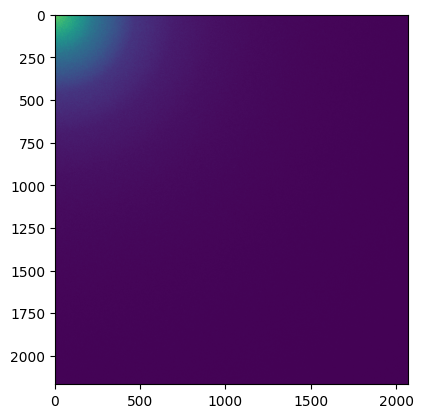

In [8]:
# display the image
fig,ax = subplots()
ax.imshow(frame)

In [9]:
print("Performances of the different algorithms for azimuthal integration of Eiger 4M image on the CPU")
for algo in ("histogram", "csc", "csr"):
    print(f"Using algorithm {algo:10s}:", end=" ")
    %timeit ai.integrate1d(img, nbins, method=("full", algo, "cython"))
print("Performances of the different algorithms for azimuthal integration of Eiger 4M image on the GPU")
print(f"Using algorithm {algo:10s}:", end=" ")
%timeit ai.integrate1d(img, nbins, method=("full", algo, "opencl", target))

Performances of the different algorithms for azimuthal integration of Eiger 4M image on the CPU
Using algorithm histogram : 589 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using algorithm csc       : 40.6 ms ± 150 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using algorithm csr       : 25.9 ms ± 385 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Performances of the different algorithms for azimuthal integration of Eiger 4M image on the GPU
Using algorithm csr       : 4.84 ms ± 16.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Note:** The full pixel splitting is time consuming and handicaps the histogram algorithm while both sparse-matrix methods are much faster since they cache this calculation in the sparse matrix.

On the Power9 computer the CPU is much slower than the GPU !

In [10]:
# How is the time spend when integrating on GPU ?
res0 = ai.integrate1d(frame, nbins, method=("full", "csr", "opencl", target))
engine = ai.engines[res0.method].engine
engine.events = []
engine.set_profiling(True)
omega_crc = engine.on_device["solidangle"]
%timeit engine.integrate_ng(img, solidangle=omega, solidangle_checksum=omega_crc)
print("\n".join(engine.log_profile(stats=True)))
engine.set_profiling(False)
engine.events = []

4.71 ms ± 15.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

OpenCL kernel profiling statistics in milliseconds for: OCL_CSR_Integrator
                                       Kernel name (count):      min   median      max     mean      std
                                   copy H->D image (  811):    1.407    1.426    1.622    1.429    0.016
                                         memset_ng (  811):    0.009    0.011    0.024    0.012    0.001
                                     corrections4a (  811):    0.179    0.181    0.186    0.181    0.001
                                    csr_integrate4 (  811):    0.394    0.396    0.399    0.396    0.001
                                  copy D->H avgint (  811):    0.002    0.002    0.002    0.002    0.000
                                     copy D->H std (  811):    0.002    0.002    0.002    0.002    0.000
                                     copy D->H sem (  811):    0.001    0.001    0.002    0.001    0.000
            

**Note:** Most of the time is spent in the transfer from the CPU to the GPU.

In [11]:
%%timeit -r1 -n1 -o -q
#Saving of a HDF5 file with many frames ...
with h5py.File(filename, "w") as h:
    ds = h.create_dataset("data", shape=(nbframes,)+shape, chunks=(1,)+shape, dtype=dtype, **cmp) 
    for i in range(nbframes):
        ds[i] = frame + i%500 #Each frame has a different value to prevent caching effects

<TimeitResult : 1min 13s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [12]:
timing_write = _
size=os.stat(filename).st_size
print(f"File size {size/(1024**3):.3f} GB with a compression ratio of {nbframes*numpy.prod(shape)*dtype.itemsize/size:.3f}x")
print(f"Write speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_write.best):.3f} MB/s of uncompressed data, or {nbframes/timing_write.best:.3f} fps.")

File size 9.213 GB with a compression ratio of 7.429x
Write speed: 1004.457 MB/s of uncompressed data, or 55.981 fps.


In [13]:
%%timeit -r1 -n1 -o -q
#Reading all frames and decompressing them
buffer = numpy.zeros(shape, dtype=dtype)
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(nbframes):
        ds.read_direct(buffer, numpy.s_[i,:,:], numpy.s_[:,:])

<TimeitResult : 42.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [14]:
timing_read1 = _
print(f"Read speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_read1.best):.3f} MB/s of uncompressed data, or {nbframes/timing_read1.best:.3f} fps.")

Read speed: 1721.759 MB/s of uncompressed data, or 95.958 fps.


In [15]:
# Time for decompressing one frame:
chunk = bitshuffle.compress_lz4(frame,0)
print(f"Compression ratio: {frame.nbytes/len(chunk):.3f}x")
timing_decompress = %timeit -o bitshuffle.decompress_lz4(chunk, frame.shape, frame.dtype, 0)
print(f"Decompression speed: {1/timing_decompress.best:.3f} fps")

Compression ratio: 9.095x
2.43 ms ± 417 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Decompression speed: 515.661 fps


In [16]:
%%timeit -r1 -n1 -o -q
#Reading all frames without decompressing them
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(ds.id.get_num_chunks()):
        filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)

<TimeitResult : 1.43 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [17]:
timing_read2 = _
print(f"Read speed: {size/(1e6*timing_read2.best):.3f} MB/s of compressed data.")
print(f"HDF5 read speed (without decompression): {nbframes/timing_read2.best:.3f} fps.")
print(f"HDF5 read speed (with decompression, theoritical): {nbframes/(timing_read2.best+timing_decompress.best*nbframes):.3f} fps.")

Read speed: 6922.496 MB/s of compressed data.
HDF5 read speed (without decompression): 2866.371 fps.
HDF5 read speed (with decompression, theoritical): 437.038 fps.


## Prepare the azimuthal integrator
To unleash the full performances of the azimuthal integrator, here the ability to deal with GPU arrays, one needs to extract the OpenCL integrator from AzimuthalIntegator. The integrator used here is a sparse matrix multiplication one with a CSR representation, tuned to run on the GPU.

In [18]:
res0 = ai.integrate1d(frame, nbins, method=("full", "csr", "opencl", target))
engine = ai.engines[res0.method].engine
#This is how the engine works. First send the image on the GPU:

timing_integration_from_mem = %timeit -r3 -o engine.integrate_ng(frame, solidangle=omega, solidangle_checksum=omega_crc)

frame_d = cla.to_device(engine.queue, frame)
omega_crc = engine.on_device["solidangle"]

res1 = engine.integrate_ng(frame_d, solidangle=omega, solidangle_checksum=omega_crc)
assert numpy.allclose(res0.intensity, res1.intensity)  # validates the equivalence of both approaches:
timing_integration = %timeit -r3 -o engine.integrate_ng(frame_d, solidangle=omega, solidangle_checksum=omega_crc)
print(f"The maximum achievable integration speed on this device is {1/timing_integration.best:.3f} fps when data are in the GPU memory,"
      f"\nbut only {1/timing_integration_from_mem.best:.3f} fps when data are still in the CPU memory !")

2.08 ms ± 18.3 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)
807 μs ± 404 ns per loop (mean ± std. dev. of 3 runs, 1,000 loops each)
The maximum achievable integration speed on this device is 1239.869 fps when data are in the GPU memory,
but only 485.766 fps when data are still in the CPU memory !


In [19]:
timimg_sum_theo = timing_integration.best + timing_read2.best/nbframes + timing_integration_from_mem.best
timimg_sum_prac = timing_read1.best/nbframes + timing_integration_from_mem.best
print(f"The maximum theoritical throughput considering reading, decompression and integration is {1/timimg_sum_theo:.3f} fps.\n"
     f"But in practice, most people achieve at best {1/timimg_sum_prac:.3f} fps, "
      "partially due to a poor implementation of decompression in HDF5.")

The maximum theoritical throughput considering reading, decompression and integration is 311.137 fps.
But in practice, most people achieve at best 80.130 fps, partially due to a poor implementation of decompression in HDF5.


**Summary:**
* Read speed: 2908 fps
* Read + decompress: 96/406 fps
* Read + decompress + integrate: 80/312 fps.

## Using the decompression on the GPU

This feature requires silx 1.2 !

In [20]:
silx.version

'3.0.0-a0'

In [21]:
# Read one chunk
with h5py.File(filename, "r") as h:
    ds = h["data"]
    i=0
    filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)

In [22]:
gpu_decompressor = BitshuffleLz4(len(chunk), frame.size, dtype=frame.dtype, ctx=engine.ctx)

In [23]:
#Tune the decompressor for the fastest speed:
best = numpy.finfo("float32").max, None
for i in range(0, 11):
    j = 1<<i
    print(f"Workgroup size {j:4d} : ", end=" ")
    res = %timeit -o gpu_decompressor.decompress(chunk, wg=j)
    if res.best<best[0]:
        best = (res.best, j)
        
print(f"\nBest performances ({best[0]:.3e}s) obtained with WG={best[1]}")
gpu_decompressor.block_size = best[1]

print(f"\nDecompression of data on the GPU occures at {1/best[0]:.3f} fps "
      f"while it is {1/timing_decompress.best:.3f} fps when performed on the CPU.")

Workgroup size    1 :  11.4 ms ± 36.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Workgroup size    2 :  6.1 ms ± 2.29 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Workgroup size    4 :  3.51 ms ± 4.08 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Workgroup size    8 :  2.22 ms ± 2.78 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Workgroup size   16 :  1.56 ms ± 3.52 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size   32 :  1.23 ms ± 490 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size   64 :  1.07 ms ± 2.91 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size  128 :  1.01 ms ± 741 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size  256 :  1.01 ms ± 1.09 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size  512 :  1.07 ms ± 3.53 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size 1024 :  1.29 ms ± 4.75 μs 

In [24]:
#Tune the integrator for the fastest speed:

def new_engine(engine, wg):
    return engine.__class__((engine._data, engine._indices, engine._indptr), 
                              engine.size, empty=engine.empty, unit=engine.unit, 
                              bin_centers=engine.bin_centers, azim_centers = engine.azim_centers,  
                              ctx=engine.ctx, block_size=wg)

best = (numpy.finfo("float32").max, None)
for i in range(0, 11):
    j = 1<<i
    print(f"Workgroup size {j:3d} : ", end=" ")
    ne = new_engine(engine, j)
    ne.integrate_ng(frame_d, solidangle=omega, solidangle_checksum=omega_crc)
    res = %timeit -o ne.integrate_ng(frame_d, solidangle=omega, solidangle_checksum=omega_crc)
    if res.best<best[0]:
        best = (res.best, j)

print(f"\nBest performances ({best[0]:.3e}s) obtained with WG={best[1]}")
engine = new_engine(engine, best[1])
print("With data on the CPU:")
timing_integrate_cpu = %timeit -o engine.integrate_ng(frame, solidangle=omega, solidangle_checksum=omega_crc)

Workgroup size   1 :  8.78 ms ± 4.57 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Workgroup size   2 :  5.54 ms ± 6.43 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Workgroup size   4 :  3.25 ms ± 911 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
Workgroup size   8 :  2.07 ms ± 6.36 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Workgroup size  16 :  1.22 ms ± 231 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size  32 :  823 μs ± 245 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size  64 :  710 μs ± 683 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size 128 :  717 μs ± 642 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size 256 :  686 μs ± 482 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size 512 :  660 μs ± 449 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Workgroup size 1024 :  660 μs ± 599 ns per loop (mean ± std.

In [25]:
print(f"Azimuthal integration of data on the GPU occures at {1/best[0]:.3f} fps\n"
      f"while it is {1/timing_integrate_cpu.best:.3f} fps when data comes from the CPU.")

Azimuthal integration of data on the GPU occures at 1516.709 fps
while it is 525.196 fps when data comes from the CPU.


In [26]:
#Build a pipeline with decompression and integration on the GPU:
%timeit engine.integrate_ng(gpu_decompressor(chunk), solidangle=omega, solidangle_checksum=omega_crc)

1.76 ms ± 761 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [27]:
result = numpy.empty((nbframes, nbins), dtype=numpy.float32)

In [28]:
%%timeit -r1 -n1 -o -q
# Process a complete stack:
with h5py.File(filename, "r") as h:
    ds = h["data"]
    for i in range(ds.id.get_num_chunks()):
        filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)
        result[i] = engine.integrate_ng(gpu_decompressor(chunk), solidangle=omega, solidangle_checksum=omega_crc).intensity

<TimeitResult : 9.91 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [29]:
timing_process_gpu = _

In [30]:
print(f"Processing speed when decompression occures on GPU: {nbframes/timing_process_gpu.best:.3f} fps "
      f"which is better than theoritical speed by {timimg_sum_theo*nbframes/timing_process_gpu.best:.3f}x.\n"
     f"It is much better than the actual speed measured by {timimg_sum_prac*nbframes/timing_process_gpu.best:.3f}x.")

Processing speed when decompression occures on GPU: 413.360 fps which is better than theoritical speed by 1.329x.
It is much better than the actual speed measured by 5.159x.


## Display some results
Since the input data were all synthetic and similar, no great science is expected from this... but one can ensure each frame differs slightly from the neighbors with a pattern of 500 frames. 

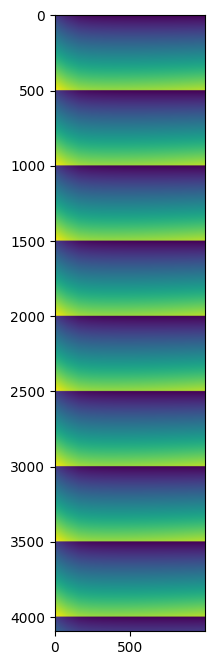

In [31]:
fig,ax = subplots(figsize=(8,8))
ax.imshow(result)

## Conclusion

Bitshuffle-LZ4 data decompression can be off-loaded to the GPU, this is especially appealing when downstream processing requires also GPU-computing like azimuthal integration.

The procedure is simpler than multi-threading approach: no queue, no threads, it just requires a GPU properly setup.

The performances measured on a (not so recent) Nvidia A5000 on a fast CPU (4.5 GHz) provide a 5x speed up.!

Those performances can be further parallelized using multiprocessing if needed (see the other tutorial in this section).

In [32]:
print(f"Total processing time: {time.time()-start_time:.3f} s")

Total processing time: 345.270 s
